In [1]:
import os
from collections import defaultdict

import PIL
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [2]:
annotation_list = pd.read_csv('/home/chris/code/nn/data/annotations/list.txt', 
                         header=None, 
                         skiprows=6, 
                         delimiter=' ',
                         names=['image', 'id', 'species', 'breed'])

annotation_test = pd.read_csv('/home/chris/code/nn/data/annotations/test.txt', 
                         header=None,
                         delimiter=' ',
                         names=['image', 'id', 'species', 'breed'])

annotation_trainval = pd.read_csv('/home/chris/code/nn/data/annotations/trainval.txt', 
                                  header=None,
                                  delimiter=' ',
                                  names=['image', 'id', 'species', 'breed'])

In [3]:
annotation_list.head()

,image,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [4]:
annotation_test.head()

,image,id,species,breed
0,Abyssinian_201,1,1,1
1,Abyssinian_202,1,1,1
2,Abyssinian_204,1,1,1
3,Abyssinian_205,1,1,1
4,Abyssinian_206,1,1,1


In [5]:
annotation_trainval.head()

,image,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [6]:
annotation_list.shape, annotation_test.shape, annotation_trainval.shape

((7349, 4), (3669, 4), (3680, 4))

In [7]:
print(len(set(annotation_list['image']).intersection(set(annotation_test['image']))))
print(len(set(annotation_list['image']).intersection(set(annotation_trainval['image']))))
print(len(set(annotation_list['image']).union(set(annotation_test['image']))))

3669
3680
7349


In [8]:
BASE_DATA_PATH = '/home/chris/code/nn/data'

data = pd.read_csv(f'{BASE_DATA_PATH}/annotations/list.txt', 
                   header=None, 
                   skiprows=6, 
                   delimiter=' ',
                   names=['image', 'label', 'species', 'breed'])

In [9]:
data.head()

,image,label,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [10]:
data['image'] = data['image'].map(lambda image_name: os.path.join(BASE_DATA_PATH, 'images', f'{image_name}.jpg'))

In [11]:
data.head()

,image,label,species,breed
0,/home/chris/code/nn/data/images/Abyssinian_100...,1,1,1
1,/home/chris/code/nn/data/images/Abyssinian_101...,1,1,1
2,/home/chris/code/nn/data/images/Abyssinian_102...,1,1,1
3,/home/chris/code/nn/data/images/Abyssinian_103...,1,1,1
4,/home/chris/code/nn/data/images/Abyssinian_104...,1,1,1


In [99]:
class SiamesePairedDataset(Dataset):
    def __init__(self, 
                 data, 
                 path_col=None, 
                 label_col=None, 
                 sampling_strategy='uniform', 
                 class_prob=None, 
                 transform=None):
        
        #### Set important class variables
        self.path_col   = path_col
        self.label_col  = label_col
        self.classes    = data[label_col].unique()
        self.transform  = transform
        self.strategy   = sampling_strategy
        self.num_images = len(data)
        
        #### Create dictionary of key: value format class_label: [list of class image paths]
        
        # Each key starting with a blank list simplifies the dictionary's construction
        self.image_dict = defaultdict(list)
        
        # Iterate through rows, adding the image file path to the appropriate class in dictionary
        for image_path, image_class in data[[path_col, label_col]].values:
            self.image_dict[image_class].append(image_path)
        
        #### Based on the specified sampling strategy, establish individual class probabilities
        
        # Each class will have equal probability of being selected regardless of size
        if self.strategy=='uniform':
            self.class_prob = np.ones(len(self.classes))
            self.class_prob = self.class_prob / np.sum(self.class_prob)
        
        # Each class selection probability proportional to prevalence
        elif self.strategy=='proportional':
            # Create an array with individual class lengths
            class_lens = np.array([len(self.image_dict[entity_class]) for image_class in self.classes])
            self.class_prob = class_lens / num_images
            
        # Each class selected according to user input of class probabilities
        elif self.strategy=='custom':
            if class_prob is not None:
                self.class_prob = class_prob
            else:
                raise Exception("For custom sampling strategy, class probabilities must be specified.")
            
        else:
            raise Exception("Invalid stratification strategy")
                
    def __len__(self):
        return self.num_images
        
    def __getitem__(self, idx):
                    
        # Get classes for both images, we'll overwrite class2 if it's a same-class example
        class1, class2 = np.random.choice(self.classes, p=self.class_prob, replace=False, size=2)
        
        #### Two cases: both drawn from same class, both drawn from different classes
        
        # Same class
        if idx % 2 == 1:
            label = 0 # Training label when images are same class
            
            # Same class, so overwrite random family2 from earlier
            class2 = class1
            
            # Select the two file path strings
            file1, file2 = np.random.choice(self.image_dict[class1], size=2, replace=False)
        
        # Different classes
        else:
            label = 1 # Training label when images are different classes
            
            # Select a random image from each dataset
            file1 = np.random.choice(self.image_dict[class1])
            file2 = np.random.choice(self.image_dict[class2])
             
        # Load the image pair
        img1 = PIL.Image.open(file1)
        img2 = PIL.Image.open(file2)
        
        if img1.mode != 'RBG':
            img1 = img1.convert('RGB')
        if img2.mode != 'RBG':
            img2 = img2.convert('RGB')
           
        # Apply any torch transforms
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        if img1.size()[0] != 3:
            print(file1, img1.size()[0])
        if img2.size()[0] != 3:
            print(file2, img2.size()[0])
            
        # Concatenate them along the channel dimension (i.e 2 3-channel  
        # images as a single "6-channel" image. Keeping them as a tuple
        # breaks some of the fastai workflows when using them, so "cheating" 
        # in this way then separating within the network gets around this problem
        return torch.cat((img1, img2), dim=0), label

In [100]:
class SiameseNetwork(nn.Module):
    def __init__(self, transfer_network):
        super().__init__()
        self.model = transfer_network
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.fc_layer = nn.Linear(num_ftrs, 2)
        
        self.num_channels = 3
        
    def forward(self, x):
        inputs1 = x[:,:self.num_channels,:,:]
        inputs2 = x[:,self.num_channels:,:,:]
        
        outputs1 = self.model(inputs1)
        outputs2 = self.model(inputs2)
        outputs = torch.abs(outputs1 - outputs2)
        outputs = self.fc_layer(outputs)
        
        return outputs

In [88]:
img = PIL.Image.open('/home/chris/code/nn/data/images/Egyptian_Mau_186.jpg')

In [89]:
transform_train(img).size()[0]

4

In [98]:
transform_train(img.convert('RGB')).size()

torch.Size([3, 224, 224])

In [101]:
traindf, testdf = train_test_split(data, stratify=data['label'])

In [102]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.RandomAffine(20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) / 0.5)
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.RandomAffine(20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) / 0.5)
])

In [103]:
train_dataset = SiamesePairedDataset(traindf,
                                     path_col='image',
                                     label_col='label',
                                     transform=transform_train)

val_dataset = SiamesePairedDataset(testdf,
                                   path_col='image',
                                   label_col='label',
                                   transform=transform_val)

In [59]:
tdl = DataLoader(train_dataset, batch_size=128)

In [65]:
next(iter(tdl))[0].size()

torch.Size([128, 6, 224, 224])

In [19]:
import fastai

In [20]:
from fastai.basic_train import *
from fastai.train import *
# from fastai.plots import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

from tqdm import tqdm_notebook

In [114]:
batch_size = 64
device = torch.device(0)

def get_model_learner():
    split_dict = {'resnet18': [26, 50],'resnet34': [41, 90], 'resnet50': [57, 124]}

    model_ft = SiameseNetwork(models.resnet18(pretrained=True))

    # databunch = DataBunch(dataloaders['train'], dataloaders['val'], device=device)
    databunch = DataBunch.create(train_dataset, val_dataset, bs=batch_size, device=device, num_workers=8)

    # Set the training criterion, usually CrossEntropy for the way we have the Siamese network set up with binary outputs
    criterion = nn.CrossEntropyLoss()

    learn = Learner(databunch, model_ft, loss_func=criterion, metrics=accuracy, layer_groups=split_model_idx(model_ft, split_dict['resnet34']))
    
    return learn

learn = get_model_learner()

In [109]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


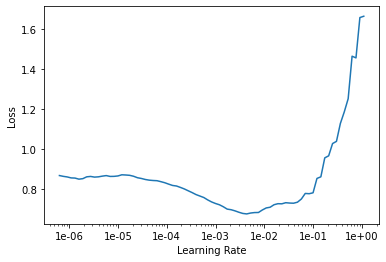

In [110]:
learn.recorder.plot()

In [115]:
lr = 1e-3
learn.fit_one_cycle(10, slice(1e-5,1e-3))#slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.689511,0.623430,0.636017,00:17
1,0.499001,0.381291,0.867247,00:17
2,0.352960,0.307799,0.896627,00:17
3,0.271863,0.262229,0.910773,00:17
4,0.229889,0.221274,0.926551,00:17
5,0.193222,0.217689,0.928183,00:17
6,0.171915,0.187001,0.938520,00:17
7,0.164740,0.183450,0.940152,00:17
8,0.159367,0.190059,0.929815,00:17
9,0.155759,0.182267,0.935800,00:17


### Try out of sample

In [119]:
classes = data['label'].unique()
classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37])

In [134]:
classes = data['label'].unique()

train_classes = np.random.choice(classes, size=25)
val_classes   = set(classes) - set(train_classes)

In [135]:
traindf = data[data['label'].map(lambda x: x in train_classes)]
valdf   = data[data['label'].map(lambda x: x in val_classes)]

In [136]:
traindf.shape, valdf.shape, data.shape, traindf.shape[0]+valdf.shape[0]

((3766, 4), (3583, 4), (7349, 4), 7349)

In [137]:
train_dataset = SiamesePairedDataset(traindf,
                                     path_col='image',
                                     label_col='label',
                                     transform=transform_train)

val_dataset = SiamesePairedDataset(testdf,
                                   path_col='image',
                                   label_col='label',
                                   transform=transform_val)

In [139]:
learn = get_model_learner()

In [128]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


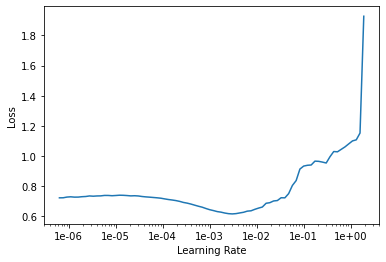

In [129]:
learn.recorder.plot()

In [141]:
learn = get_model_learner()
learn.fit_one_cycle(5, slice(1e-5,1e-3))#slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.651586,0.541191,0.740479,00:13
1,0.444226,0.387888,0.853645,00:12
2,0.328449,0.332162,0.879217,00:13
3,0.269536,0.309886,0.890642,00:13
4,0.244579,0.299073,0.898803,00:13


In [140]:
learn = get_model_learner()
learn.fit_one_cycle(10, slice(1e-5,1e-3))#slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.736547,0.674226,0.608814,00:13
1,0.557549,0.469041,0.813384,00:13
2,0.396460,0.361778,0.869423,00:13
3,0.300332,0.317647,0.883025,00:13
4,0.242726,0.300183,0.885201,00:13
5,0.199364,0.255350,0.910228,00:13
6,0.176397,0.261000,0.905876,00:13
7,0.159286,0.259063,0.908596,00:13
8,0.149418,0.240323,0.911317,00:13
9,0.144010,0.234478,0.917301,00:13


In [142]:
learn = get_model_learner()
learn.fit_one_cycle(15, slice(1e-5,1e-3))#slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.719083,0.680082,0.566377,00:13
1,0.614482,0.539819,0.743199,00:13
2,0.469343,0.406225,0.849293,00:13
3,0.351089,0.351357,0.871600,00:13
4,0.277894,0.284503,0.907508,00:13
5,0.219115,0.273071,0.895539,00:13
6,0.190474,0.245117,0.910228,00:13
7,0.155954,0.256679,0.905332,00:13
8,0.135453,0.233850,0.908596,00:13
9,0.122757,0.209354,0.916213,00:13
